<a href="https://colab.research.google.com/github/guico3lho/NLP_UnB_2022_1/blob/main/Atividade_7_NLI_160123046.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import requests
import re
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, SimpleRNN, Activation, Embedding, Bidirectional, LSTM
import matplotlib.pyplot as plt


# Classes and Functions

In [2]:
#@ Classes

class Train:
    def __init__(self, ds_train):
        self.df = None
        self.raw_df = None
        self.sentences = None
        self.labels = None
        self.sequences = None
        self.padded = None

        # take 10000 rows of premise and hypothesis sentences
        self.raw_df = tfds.as_dataframe(ds_train.take(10000))
        # concatenate premise and hypothesis into one sentence
        self.raw_df['premise_hyp'] = self.raw_df.apply(lambda x: conc(str(x['premise']), str(x['hypothesis'])), axis=1)
        # select only desired columns
        self.raw_df = self.raw_df[['premise_hyp', 'label']]
        self.df = self.raw_df.copy()
        # normalize sentences
        self.df['premise_hyp'] = self.df['premise_hyp'].apply(lambda x: normalizarString(x))
        self.df = self.df[self.df['label'] != -1]
        self.sentences = []
        self.labels = []
        for i, row in self.df.iterrows():
            self.sentences.append(row[0])
            self.labels.append(row[1])


class Validation:
    def __init__(self, ds_validation):
        self.df = None
        self.raw_df = None
        self.sentences = None
        self.labels = None
        self.sequences = None
        self.padded = None

        # take 10000 rows of premise and hypothesis sentences
        self.raw_df = tfds.as_dataframe(ds_validation.take(2500))

        # concatenate premise and hypothesis into one sentence
        self.raw_df['premise_hyp'] = self.raw_df.apply(lambda x: conc(str(x['premise']), str(x['hypothesis'])), axis=1)
        # select only desired columns
        self.raw_df = self.raw_df[['premise_hyp', 'label']]
        self.df = self.raw_df.copy()
        # normalize sentences
        self.df['premise_hyp'] = self.df['premise_hyp'].apply(lambda x: normalizarString(x))
        self.df = self.df[self.df['label'] != -1]

        self.sentences = []
        self.labels = []
        for i, row in self.df.iterrows():
            self.sentences.append(row[0])
            self.labels.append(row[1])


class Test:
    def __init__(self, ds_test):
        self.df = None
        self.raw_df = None
        self.sentences = None
        self.labels = None
        self.sequences = None
        self.padded = None

        # take 10000 rows of premise and hypothesis sentences
        self.raw_df = tfds.as_dataframe(ds_test.take(2500))

        # concatenate premise and hypothesis into one sentence
        self.raw_df['premise_hyp'] = self.raw_df.apply(lambda x: conc(str(x['premise']), str(x['hypothesis'])), axis=1)
        # select only desired columns
        self.raw_df = self.raw_df[['premise_hyp', 'label']]
        self.df = self.raw_df.copy()
        # normalize sentences
        self.df['premise_hyp'] = self.df['premise_hyp'].apply(lambda x: normalizarString(x))
        self.df = self.df[self.df['label'] != -1]

        self.sentences = []
        self.labels = []
        for i, row in self.df.iterrows():
            self.sentences.append(row[0])
            self.labels.append(row[1])


class HyperParameters:
    def __init__(self, vocab_size, embedding_dim, max_length, trunc_type, padding_type, epochs):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.trunc_type = trunc_type
        self.padding_type = padding_type
        self.epochs = epochs


class Models:

    def __init__(self, model_name, train, validation,test, hp):
        self.model_name = model_name
        self.hp = hp
        self.model = self.choose_model()
        self.train = train
        self.validation = validation
        self.test = test
        self.history = None
        self.metrics = {
            'accuracy': 'accuracy',
            'loss': 'loss',
        }


    def choose_model(self):
        if self.model_name == 'rnn':
            model = Sequential([
                Embedding(self.hp.vocab_size, self.hp.embedding_dim, input_length=self.hp.max_length),
                SimpleRNN(32),
                Dense(10, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            ...
            model.summary()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        elif self.model_name == 'lstm':
            model = Sequential([
                Embedding(self.hp.vocab_size, self.hp.embedding_dim, input_length=self.hp.max_length),
                LSTM(32),
                Dense(10, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            ...
            model.summary()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        elif self.model_name == 'bilstm':
            model = Sequential([
                Embedding(self.hp.vocab_size, self.hp.embedding_dim, input_length=self.hp.max_length),
                Bidirectional(LSTM(32)),
                Dense(10, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            ...
            model.summary()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model


    def fit(self):
        self.history = self.model.fit(self.train.padded, self.train.labels, epochs=self.hp.epochs,
                                      validation_data=(self.validation.padded, self.validation.labels), verbose=2)

    def show_plot(self, metric):
        plt.plot(self.history.history[metric])
        plt.plot(self.history.history['val_' + metric], '')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_' + metric])
        plt.title(self.model_name + ' ' + metric)
        plt.show()

In [3]:
#@ Auxiliary functions

def createWordIndexCustom(vocabulary):
    word_index = {}
    for word, index in vocabulary.items():
        word_index[word] = index
    return word_index


def createWordIndex(hp, train, validation, test):
    # creates word_index for vocabulary
    tokenizer = Tokenizer(num_words=hp.vocab_size)
    # fit_on_texts receives a list of sentences. Can be a series of dataframe too
    tokenizer.fit_on_texts(train.sentences)

    train.sequences = tokenizer.texts_to_sequences(train.sentences)
    validation.sequences = tokenizer.texts_to_sequences(validation.sentences)
    test.sequences = tokenizer.texts_to_sequences(test.sentences)

    #
    # max_len = len(train.sequences[0])
    # for train,valid,test in zip(train.sequences,validation.sequences,test.sequences):
    #     if max(len(train),len(valid),len(test)) > max_len:
    #         max_len = max(len(train),len(valid),len(test))



    train.padded = pad_sequences(train.sequences, maxlen=hp.max_length, padding=hp.padding_type,
                                 truncating=hp.trunc_type)
    validation.padded = pad_sequences(validation.sequences, maxlen=hp.max_length, padding=hp.padding_type,
                                      truncating=hp.trunc_type)
    test.padded = pad_sequences(test.sequences, maxlen=hp.max_length, padding=hp.padding_type, truncating=hp.trunc_type)

    train.labels = np.array(train.labels)
    validation.labels = np.array(validation.labels)
    test.labels = np.array(test.labels)




def createVocabulary(train):
    vocabulary = {}
    for i in range(0, len(train.sentences)):
        for word in train.sentences[i].split():
            if word in vocabulary:
                vocabulary[word] += 1
            else:
                vocabulary[word] = 1
    return vocabulary


def conc(x, y):
    return x + y


def normalizarString(text):
    import unicodedata

    text = text.lower()
    text = re.sub(r'(b\')|(\')', '', text)
    return text


def usingStopwords():
    master = "https://raw.githubusercontent.com/guico3lho/NLP_UnB_2022_1/main/stopwords_pt.txt"
    req = requests.get(master)
    text = req.text

    stop_words = []
    pattern = r'\n?'
    rt = re.compile(pattern)

    for i in text.split('\n'):
        stop_words.append(normalizarString(rt.sub('', i)))
    print(f'Fim do Preenchimento das stopwords')

    return stop_words


# Execution

In [8]:
stopwords = usingStopwords()
ds_train = tfds.load('snli', split='train', shuffle_files=True)
ds_validation = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)

Fim do Preenchimento das stopwords


In [10]:
# preparing data
train = Train(ds_train)
validation = Validation(ds_validation)
test = Test(ds_test)
print("raw df_train:")
display(train.raw_df)
print("df_train after removel of label (-2) and preprocessing")
display(train.df)

raw df_train:


,premise_hyp,label
0,b'A man washes or dies clothes in a primitive ...,1
1,b'A woman is walking her baby with a stroller ...,2
2,b'This is a pensive women in a grassy setting....,-1
3,b'Woman in red shirt and white cap rollerbladi...,1
4,b'A group of African children dressed in misma...,1
...,...,...
9995,b'A little girl in a pink bathing suit swimmin...,2
9996,b'Woman bent over talking on phone.'b'A woman ...,2
9997,b'A large dog frolics in the grass.'b'a chicke...,2
9998,b'Two people wearing backpacks cross a rickety...,0


df_train after removel of label (-2) and preprocessing


,premise_hyp,label
0,a man washes or dies clothes in a primitive se...,1
1,a woman is walking her baby with a stroller at...,2
3,woman in red shirt and white cap rollerblading...,1
4,a group of african children dressed in mismatc...,1
5,a group of motorcycles and scooters are parked...,0
...,...,...
9995,a little girl in a pink bathing suit swimming ...,2
9996,woman bent over talking on phone.a woman is ta...,2
9997,a large dog frolics in the grass.a chicken pecs,2
9998,two people wearing backpacks cross a rickety c...,0


In [11]:
vocabulary = createVocabulary(train)
    
hp = HyperParameters(vocab_size=len(vocabulary), embedding_dim=16, max_length=72, trunc_type='post',
                         padding_type='post', epochs=30)

createWordIndex(hp, train, validation, test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 72, 16)            249952    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 251,861
Trainable params: 251,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
312/312 - 8s - loss: 0.0636 - accuracy: 0.3266 - val_loss: -1.5719e-01 - val_accuracy: 0.3219 - 8s/epoch - 27ms/step
Epoch 2/30
312/312 - 7s - loss: 0.0379 - accuracy: 0

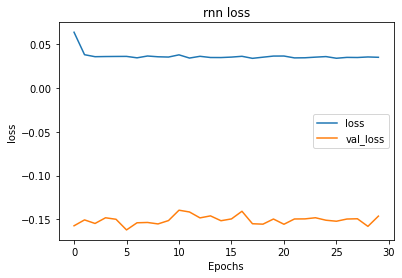

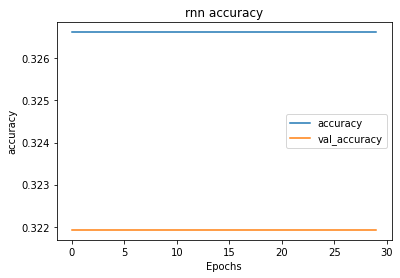

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 72, 16)            249952    
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 256,565
Trainable params: 256,565
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
312/312 - 11s - loss: 0.1477 - accuracy: 0.3258 - val_loss: -1.0613e-01 - val_accuracy: 0.3219 - 11s/epoch - 36ms/step
Epoch 2/30
312/312 - 9s - loss: 0.0357 - accuracy:

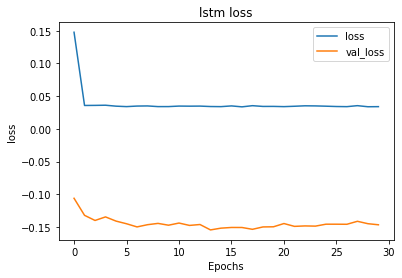

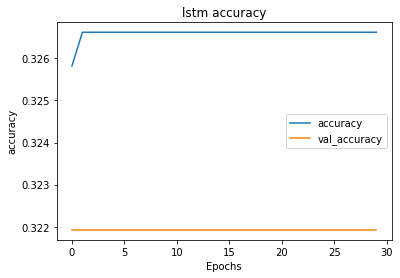

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 72, 16)            249952    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 263,157
Trainable params: 263,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
312/312 - 48s - loss: 0.0854 - accuracy: 0.3266 - val_loss: -1.4254e-01 - val_accuracy: 0.3219 - 48s/ep

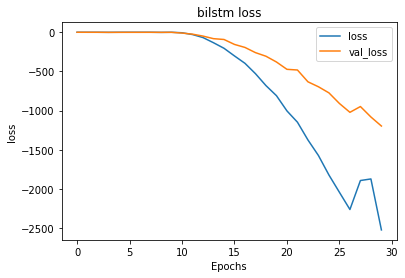

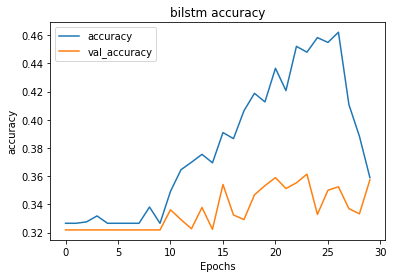

In [12]:
rnn_model = Models('rnn', train, validation, test, hp)
rnn_model.fit()
rnn_model.show_plot('loss')
rnn_model.show_plot('accuracy')

lstm_model = Models('lstm', train, validation, test, hp)
lstm_model.fit()
lstm_model.show_plot('loss')
lstm_model.show_plot('accuracy')


bilstm_model = Models('bilstm', train, validation, test, hp)
bilstm_model.fit()
bilstm_model.show_plot('loss')
bilstm_model.show_plot('accuracy')